### Importing libraries and data cleaning

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display in float
pd.set_option('display.float_format', lambda x: '%.3f' % x)

CSV_PATH = 'movies.csv'

df = pd.read_csv(CSV_PATH)


# We filter movies after year 2000
cleaned_df = df[df['year'] >= 2000]
# We drop NaN rows
cleaned_df = cleaned_df.dropna()

### 1. Ratings vs Gross


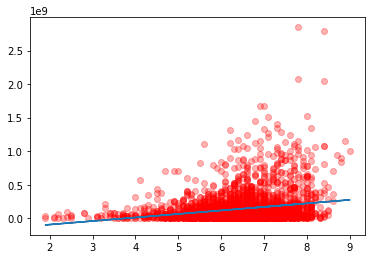

In [101]:
score_gross = cleaned_df[['score','gross']]
plt.scatter(score_gross['score'],      
            score_gross['gross'],      
            c='r', alpha=0.3)      

m, b = np.polyfit(score_gross['score'],score_gross['gross'], 1)
plt.plot(score_gross['score'], m * score_gross['score'] + b);


### 2. Genre that the audience enjoys (Genre vs Score/Gross)

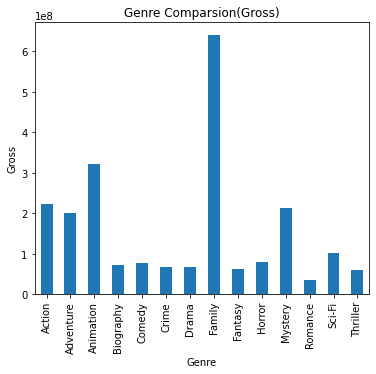

In [106]:
group_by_genre_df = cleaned_df.groupby('genre')
gross_mean_across_genre = group_by_genre_df['gross'].mean()

gross_mean_across_genre.plot(kind='bar', title='Genre Comparsion(Gross)', ylabel='Gross',
         xlabel='Genre', figsize=(6, 5));

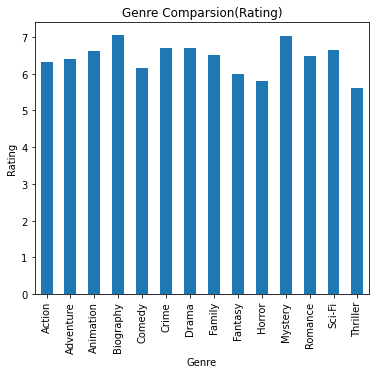

In [110]:
gross_mean_across_genre = group_by_genre_df['score'].mean()
gross_mean_across_genre.plot(kind='bar', title='Genre Comparsion(Rating)', ylabel='Rating',
         xlabel='Genre', figsize=(6, 5));

### 3. Budget vs Score

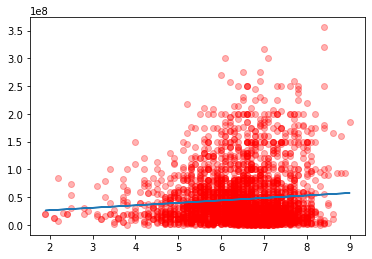

In [113]:
budget_score = cleaned_df[['score','budget']]
plt.scatter(budget_score['score'],      
            budget_score['budget'],      
            c='r', alpha=0.3)      

m, b = np.polyfit(budget_score['score'],budget_score['budget'], 1)
plt.plot(budget_score['score'], m * budget_score['score'] + b);


### 4. IMDB number of votes vs score

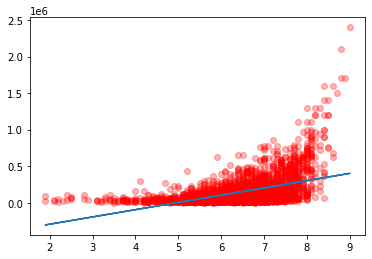

In [115]:
score_votes = cleaned_df[['score','votes']]
plt.scatter(score_votes['score'],      
            score_votes['votes'],      
            c='r', alpha=0.3)      

m, b = np.polyfit(score_votes['score'],score_votes['votes'], 1)
plt.plot(score_votes['score'], m * score_votes['score'] + b);
